# Accidents over time
Given a sharded MongoDB cluster, we can now use it to store and query the entire accidents database, from 2009–12 inclusive. 

Note that this database only just fits in the memory of the VM. Before you start the activities in this Notebook, make sure you have no other running Notebooks. 

If any of the queries takes more than a few minutes to complete, it's probably because one of the shard servers has run out of memory and failed. Rerun the first three cells and try again. 

If you get more than a couple of failures, reboot the whole VM (_not_ suspend) and try again.

Stop the single-server Mongo instance and start the shard cluster. Look at the output of this command: it could well have failures the first time you run it. If so, just run it again until it works.

In [1]:
!sudo service mongod stop
!sudo /etc/mongo-shards-down
!sudo /etc/mongo-shards-up

/etc/mongo-shards-down: line 4: /vagrant/logs/mongocluster_*pid: No such file or directory
Killing process  found in /vagrant/logs/mongocluster_*pid
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
Wait a mo to check processes are down...
...ok
Starting config server...
about to fork child process, waiting until server is ready for connections.
forked process: 4334
child process started successfully, parent exiting
Sleep for 5...
...done
Configuring config replica set
MongoDB shell version v3.4.4
connecting to: mongodb://127.0.0.1:57050/
MongoDB server version: 3.4.4
{
	"_id" : "c1",
	"members" : [
		{
			"_id" : 0,
			"host" : "localhost:57050"
		}
	]
}
{
	"info" : "try querying local.system.replset to see current configuration",
	"ok" : 0,
	"errmsg" : "already initialized",
	"code" : 23,
	"codeName" : "AlreadyInitialized"
}
bye
Sleep for 5...
...done
2018-03-12T16:36:47.819+0000 W SHARDING [main] Running a sharded cluster with fewer than 3 

In [2]:
# Import the required libraries and open the connection to Mongo

import collections
import datetime
import matplotlib as mpl

import pandas as pd
import scipy.stats

import folium
import uuid

import pymongo

In [3]:
# Open a connection to the Mongo server, open the accidents database and name the collections of accidents and labels

# Note the different port number for this cluster
client = pymongo.MongoClient('mongodb://localhost:27017/')

db = client.accidents
accidents = db.accidents
labels = db.labels
roads = db.roads

## Rerun cells above
If a map-reduce query fails, try rerunning the cells above to restart the Mongo shard cluster.

In [4]:
# Load the expanded names of keys and human-readable codes into memory

expanded_name = collections.defaultdict(str)
for e in labels.find({'expanded': {"$exists": True}}):
    expanded_name[e['label']] = e['expanded']
    
label_of = collections.defaultdict(str)
for l in labels.find({'codes': {"$exists": True}}):
    for c in l['codes']:
        try:
            label_of[l['label'], int(c)] = l['codes'][c]
        except ValueError: 
            label_of[l['label'], c] = l['codes'][c]

The small_accidents database only included data for 2012. The full database includes data from 2009–12. How much data?

In [5]:
accidents.find().count()

615013

In [6]:
roads.find().count()

103529

We can summarise the data with an aggregation pipeline that will show the number of accidents each month over the seven years.

In [7]:
pipeline = [
    {'$project': {'month': {'$month': '$Datetime'},
                  'year': {'$year': '$Datetime'}}},
    {'$group': {'_id': {'month': '$month', 'year': '$year'},
                'count': {'$sum': 1}}},
    {'$sort': {'_id': 1}}
]
results = list(accidents.aggregate(pipeline))
results

[{'_id': {'month': 1, 'year': 2009}, 'count': 13417},
 {'_id': {'month': 1, 'year': 2010}, 'count': 10637},
 {'_id': {'month': 1, 'year': 2011}, 'count': 11761},
 {'_id': {'month': 1, 'year': 2012}, 'count': 11836},
 {'_id': {'month': 2, 'year': 2009}, 'count': 10950},
 {'_id': {'month': 2, 'year': 2010}, 'count': 11724},
 {'_id': {'month': 2, 'year': 2011}, 'count': 11150},
 {'_id': {'month': 2, 'year': 2012}, 'count': 10863},
 {'_id': {'month': 3, 'year': 2009}, 'count': 13202},
 {'_id': {'month': 3, 'year': 2010}, 'count': 13165},
 {'_id': {'month': 3, 'year': 2011}, 'count': 12432},
 {'_id': {'month': 3, 'year': 2012}, 'count': 12171},
 {'_id': {'month': 4, 'year': 2009}, 'count': 12715},
 {'_id': {'month': 4, 'year': 2010}, 'count': 12248},
 {'_id': {'month': 4, 'year': 2011}, 'count': 12342},
 {'_id': {'month': 4, 'year': 2012}, 'count': 10820},
 {'_id': {'month': 5, 'year': 2009}, 'count': 13811},
 {'_id': {'month': 5, 'year': 2010}, 'count': 13220},
 {'_id': {'month': 5, 'year'

We can put that in a *pandas* Series and plot the number of accidents over time. Note that we're building the series from a `dict` so that *pandas* will keep the data items in date order.

2009-01-31    13417
2009-02-28    10950
2009-03-31    13202
2009-04-30    12715
2009-05-31    13811
2009-06-30    13936
2009-07-31    14300
2009-08-31    13415
2009-09-30    13792
2009-10-31    14834
2009-11-30    15473
2009-12-31    13709
2010-01-31    10637
2010-02-28    11724
2010-03-31    13165
2010-04-30    12248
2010-05-31    13220
2010-06-30    13644
2010-07-31    13527
2010-08-31    13027
2010-09-30    13904
2010-10-31    14429
2010-11-30    14544
2010-12-31    10345
2011-01-31    11761
2011-02-28    11150
2011-03-31    12432
2011-04-30    12342
2011-05-31    12623
2011-06-30    13048
2011-07-31    13118
2011-08-31    12031
2011-09-30    13339
2011-10-31    13748
2011-11-30    13197
2011-12-31    12685
2012-01-31    11836
2012-02-29    10863
2012-03-31    12171
2012-04-30    10820
2012-05-31    12439
2012-06-30    11470
2012-07-31    12818
2012-08-31    11878
2012-09-30    13066
2012-10-31    13120
2012-11-30    13305
2012-12-31    11785
Freq: M, dtype: int64

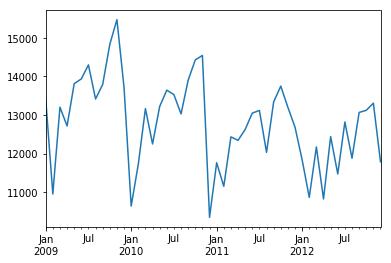

In [8]:
accidents_by_month_ss = pd.Series({datetime.datetime(m['_id']['year'], m['_id']['month'], 1): 
                                m['count'] for m in results})
# A hack to change the dates to the end of the month
accidents_by_month_ss.index = accidents_by_month_ss.index.to_period('M').to_timestamp('M')
accidents_by_month_ss.plot()
accidents_by_month_ss

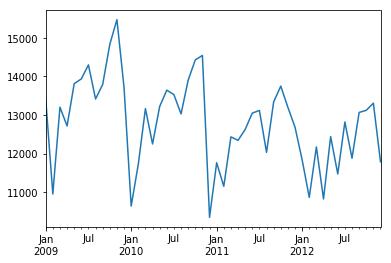

In [9]:
accidents_by_month_ss.plot()

That looks like a significant drop in the number of accidents, though the plot could be deceptive as the *y*-axis doesn't go to zero. Let's plot that again showing zero on the *y*-axis.

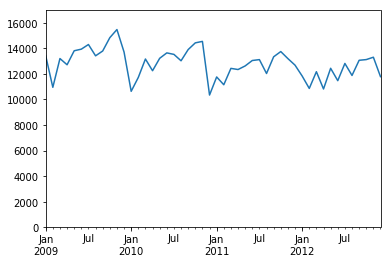

In [13]:
accidents_by_month_ss.plot(ylim=(0, accidents_by_month_ss.max() * 1.1))

Still a significant decrease in the number of accidents. Is this because people were driving less?

Let's summarise the road data, but that's only data for each year.

## Activity 1
Use an aggregation pipeline to find the total volume of traffic, grouped by year.

Were the lower accident volumes reported since 2009 because of less traffic?

The solution is in the [`16.1solutions`](16.1solutions.ipynb) Notebook.

In [15]:
pipeline = [
    {'$group': {'_id': '$AADFYear',
               'count': {'$sum': '$FdAll_MV'}}},
    {'$sort': {'_id': 1}}
]
results = list(roads.aggregate(pipeline))
results

[{'_id': 2009, 'count': 394596306.0},
 {'_id': 2010, 'count': 383385741.0},
 {'_id': 2011, 'count': 384445046.0},
 {'_id': 2012, 'count': 383755811.0},
 {'_id': 2013, 'count': 13863156}]

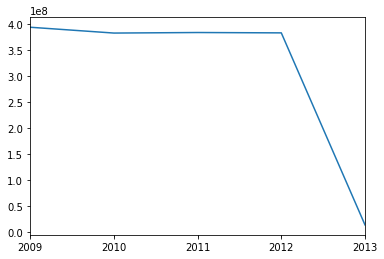

In [17]:
traffic_volume_by_year = pd.Series([y['count'] for y in results],
                                  index=pd.to_datetime([datetime.datetime(y['_id'], 12, 31) for y in results]))
traffic_volume_by_year.plot()

lets look at traffic volume from just 2009-2012

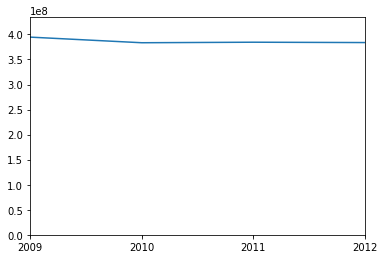

In [19]:
pipeline = [
    {'$match': {'AADFYear': {'$lte': 2012}}},
    {'$group': {'_id': '$AADFYear',
               'count': {'$sum': '$FdAll_MV'}}},
    {'$sort': {'_id': 1}}
]
results = list(roads.aggregate(pipeline))
traffic_volume_by_year = pd.Series([y['count'] for y in results],
                                  index=pd.to_datetime([datetime.datetime(y['_id'], 12, 31) for y in results]))
# add ylim 0 to get a better sense of any change
traffic_volume_by_year.plot(ylim=(0, traffic_volume_by_year.max()*1.1))

## Activity 2: Proportions of accidents at severity levels over time
Are cars getting safer? In other words, are there proportionally more slight accidents than serious or fatal, and more serious accidents than fatal?

Use an aggregation pipeline to find the number of accidents of each severity for each year. Use an appropriate statistical test to see if the proportions of accidents at each severity are significantly different over time.

The solution is in the [`16.1solutions`](16.1solutions.ipynb) Notebook.

In [21]:
# Generate the data.
pipeline = [
    {'$project': {'Accident_Severity': '$Accident_Severity',
                  'year': {'$year': '$Datetime'}}},
    {'$group': {'_id': {'Accident_Severity': '$Accident_Severity',
                        'year': '$year'},
                'count': {'$sum': 1}}},
    {'$sort': {'_id': 1}}
]
results = list(accidents.aggregate(pipeline))
results

[{'_id': {'Accident_Severity': 1, 'year': 2009}, 'count': 2057},
 {'_id': {'Accident_Severity': 2, 'year': 2009}, 'count': 21997},
 {'_id': {'Accident_Severity': 3, 'year': 2009}, 'count': 139500},
 {'_id': {'Accident_Severity': 1, 'year': 2010}, 'count': 1731},
 {'_id': {'Accident_Severity': 2, 'year': 2010}, 'count': 20440},
 {'_id': {'Accident_Severity': 3, 'year': 2010}, 'count': 132243},
 {'_id': {'Accident_Severity': 1, 'year': 2011}, 'count': 1797},
 {'_id': {'Accident_Severity': 2, 'year': 2011}, 'count': 20986},
 {'_id': {'Accident_Severity': 3, 'year': 2011}, 'count': 128691},
 {'_id': {'Accident_Severity': 1, 'year': 2012}, 'count': 1637},
 {'_id': {'Accident_Severity': 2, 'year': 2012}, 'count': 20901},
 {'_id': {'Accident_Severity': 3, 'year': 2012}, 'count': 123033}]

In [22]:
# put in to a dataframe
severity_by_year_long_df = pd.DataFrame([
        {'Accident_Severity': r['_id']['Accident_Severity'],
         'year': r['_id']['year'],
         'count': r['count']}
        for r in results
    ])
severity_by_year_long_df

,Accident_Severity,count,year
0,1,2057,2009
1,2,21997,2009
2,3,139500,2009
3,1,1731,2010
4,2,20440,2010
5,3,132243,2010
6,1,1797,2011
7,2,20986,2011
8,3,128691,2011
9,1,1637,2012


In [24]:
# pivot the df, index by year and relabel the columns
severity_by_year_df = severity_by_year_long_df.pivot('year', 'Accident_Severity', 'count')
severity_by_year_df.columns = [label_of['Accident_Severity', c] for c in severity_by_year_df.columns]
severity_by_year_df

,Fatal,Serious,Slight
year,,,
2009,2057,21997,139500
2010,1731,20440,132243
2011,1797,20986,128691
2012,1637,20901,123033


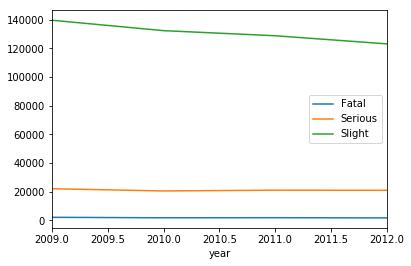

In [25]:
severity_by_year_df.plot()

The trends are difficult to spot because there are so many more slight accidents compared to the other types. What if we plot the trends using different y axes?

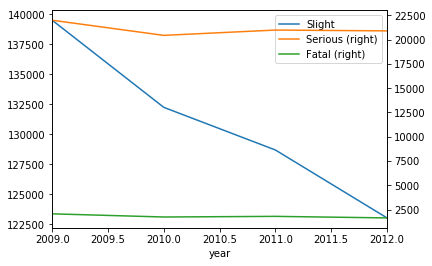

In [26]:
severity_by_year_df['Slight'].plot(legend=True)
severity_by_year_df['Serious'].plot(secondary_y=True, legend=True)
severity_by_year_df['Fatal'].plot(secondary_y=True, legend=True)

This plot shows that the numbers of fatal and serious accidents have declined slightly faster than slight accidents. 

Now we have the data, do pairwise Pearson's *R*<sup>2</sup> tests to see if the correlations are significant. If the mix of accidents changes, we should expect to see non-significant correlations.

In [27]:
scipy.stats.pearsonr(severity_by_year_df['Slight'], severity_by_year_df['Serious'])

(0.63704780013140527, 0.36295219986859478)

In [28]:
scipy.stats.pearsonr(severity_by_year_df['Slight'], severity_by_year_df['Fatal'])

(0.9150934674927067, 0.084906532507293311)

In [29]:
scipy.stats.pearsonr(severity_by_year_df['Serious'], severity_by_year_df['Fatal'])

(0.87262050802359192, 0.1273794919764081)

These results all have _p_ values (the second of the two returned) greater than 0.05, so we cannot reject the null hypothesis that the trends are uncorrelated. In other words, we cannot say that the proportions of accidents have remained the same.

## Cleanup

In [31]:
!sudo /etc/mongo-shards-down
!sudo service mongod start

Killing process 4334 found in /vagrant/logs/mongocluster_cfg-a2.pid
Killing process 4426 found in /vagrant/logs/mongocluster_mongos-2.pid
Killing process 4450 found in /vagrant/logs/mongocluster_s0-r0.pid
Killing process 4545 found in /vagrant/logs/mongocluster_s1-r0.pid
Killing process 4640 found in /vagrant/logs/mongocluster_s2-r0.pid
Wait a mo to check processes are down...
...ok


## What next?
If you are working through this Notebook as part of an inline exercise, return to the module materials now.

If you are working through this set of Notebooks as a whole, move on to `16.2 Python map-reduce`.